# Solving PDEs with ModelingToolkit and NeuralPDE

Solving Poisson PDE Systems

$$
\partial^{2}_{x}u(x,y) + \partial^{2}_{y}u(x,y) = -\sin (\pi x) \sin (\pi y)
$$

with boundary conditions

$$
\begin{align}
u(0, y) &= 0 \\
u(1, y) &= 0 \\
u(x, 0) &= 0 \\
u(x, 1) &= 0 \\
\end{align}
$$

where

$x ∈ [0, 1], y ∈ [0, 1]$

In [1]:
using NeuralPDE
using Lux
using Plots
using Optimization
using OptimizationOptimJL
using ModelingToolkit
using ModelingToolkit: Interval

[ Info: Precompiling IJuliaExt [2f4121a4-3b3a-5ce6-9c5e-1f2673ce168a]


In [2]:
@variables x y u(..)
Dxx = Differential(x)^2
Dyy = Differential(y)^2

Differential(y) ∘ Differential(y)

2D PDE equations

In [3]:
eq  = Dxx(u(x, y)) + Dyy(u(x, y)) ~ -sinpi(x) * sinpi(y)

Differential(y)(Differential(y)(u(x, y))) + Differential(x)(Differential(x)(u(x, y))) ~ -sinpi(x)*sinpi(y)

Boundary conditions

In [4]:
bcs = [
    u(0, y) ~ 0.0, u(1, y) ~ 0.0,
    u(x, 0) ~ 0.0, u(x, 1) ~ 0.0
]

4-element Vector{Equation}:
 u(0, y) ~ 0.0
 u(1, y) ~ 0.0
 u(x, 0) ~ 0.0
 u(x, 1) ~ 0.0

Space domains

In [5]:
domains = [
    x ∈ Interval(0.0, 1.0),
    y ∈ Interval(0.0, 1.0)
]

2-element Vector{Symbolics.VarDomainPairing}:
 Symbolics.VarDomainPairing(x, 0.0 .. 1.0)
 Symbolics.VarDomainPairing(y, 0.0 .. 1.0)

Build a neural network for the PDE solver.

In [6]:
dim = 2
chain = Lux.Chain(Dense(dim, 16, Lux.σ), Dense(16, 16, Lux.σ), Dense(16, 1))

Chain(
    layer_1 = Dense(2 => 16, sigmoid_fast),  # 48 parameters
    layer_2 = Dense(16 => 16, sigmoid_fast),  # 272 parameters
    layer_3 = Dense(16 => 1),           # 17 parameters
)         # Total: 337 parameters,
          #        plus 0 states.

Discretization method uses `PhysicsInformedNN()` (PINN).

In [7]:
dx = 0.05
discretization = PhysicsInformedNN(chain, GridTraining(dx))

PhysicsInformedNN{GridTraining{Float64}, Nothing, NeuralPDE.Phi{Chain{@NamedTuple{layer_1::Dense{true, typeof(sigmoid_fast), typeof(glorot_uniform), typeof(zeros32)}, layer_2::Dense{true, typeof(sigmoid_fast), typeof(glorot_uniform), typeof(zeros32)}, layer_3::Dense{true, typeof(identity), typeof(glorot_uniform), typeof(zeros32)}}}, @NamedTuple{layer_1::@NamedTuple{}, layer_2::@NamedTuple{}, layer_3::@NamedTuple{}}}, typeof(NeuralPDE.numeric_derivative), Bool, Nothing, Nothing, Nothing, Base.Pairs{Symbol, Union{}, Tuple{}, @NamedTuple{}}}(Chain{@NamedTuple{layer_1::Dense{true, typeof(sigmoid_fast), typeof(glorot_uniform), typeof(zeros32)}, layer_2::Dense{true, typeof(sigmoid_fast), typeof(glorot_uniform), typeof(zeros32)}, layer_3::Dense{true, typeof(identity), typeof(glorot_uniform), typeof(zeros32)}}}((layer_1 = Dense(2 => 16, sigmoid_fast), layer_2 = Dense(16 => 16, sigmoid_fast), layer_3 = Dense(16 => 1)), nothing), GridTraining{Float64}(0.05), nothing, NeuralPDE.Phi{Chain{@NamedTu

Next we build our PDE system and discretize it.
Because this system is time-invariant, the result is an `OptimizationProblem`.

In [8]:
@named pde_system = PDESystem(eq, bcs, domains, [x, y], [u(x, y)])
prob = discretize(pde_system, discretization)

OptimizationProblem. In-place: true
u0: ComponentVector{Float64}(layer_1 = (weight = [-0.1413305103778839 0.10120970755815506; 0.42053958773612976 0.48229968547821045; … ; -0.36676064133644104 -0.4017721712589264; -0.5734462141990662 -0.5428400039672852], bias = [0.0; 0.0; … ; 0.0; 0.0;;]), layer_2 = (weight = [-0.3497912883758545 -0.42720186710357666 … 0.2714501619338989 0.15424557030200958; 0.11080615222454071 0.2652634084224701 … 0.419251024723053 0.19123965501785278; … ; 0.3631807267665863 -0.05820924788713455 … -0.2368033528327942 0.12221387773752213; -0.3003222346305847 0.046090416610240936 … -0.20991447567939758 -0.15145565569400787], bias = [0.0; 0.0; … ; 0.0; 0.0;;]), layer_3 = (weight = [0.15774790942668915 0.345429390668869 … -0.3789818286895752 -0.325247198343277], bias = [0.0;;]))

In [9]:
alg = OptimizationOptimJL.BFGS()

BFGS{LineSearches.InitialStatic{Float64}, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}, Nothing, Nothing, Flat}(LineSearches.InitialStatic{Float64}
  alpha: Float64 1.0
  scaled: Bool false
, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}
  delta: Float64 0.1
  sigma: Float64 0.9
  alphamax: Float64 Inf
  rho: Float64 5.0
  epsilon: Float64 1.0e-6
  gamma: Float64 0.66
  linesearchmax: Int64 50
  psi3: Float64 0.1
  display: Int64 0
  mayterminate: Base.RefValue{Bool}
, nothing, nothing, Flat())

Callback function

In [10]:
larr = Float64[]
callback = function (p, l)
    push!(larr, l)
    return false
end

#1 (generic function with 1 method)

Solve the problem.

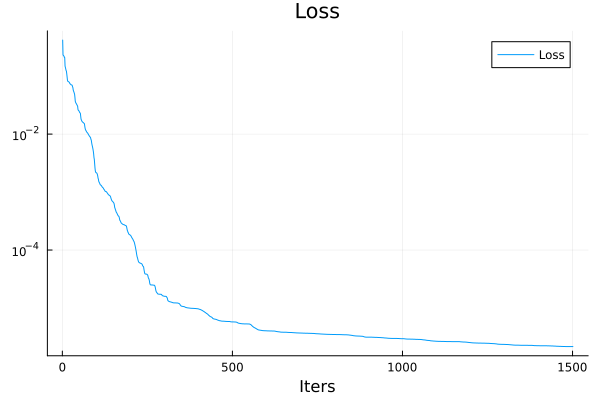

In [11]:
res = Optimization.solve(prob, alg, callback = callback, maxiters=1500)
plot(larr, xlabel="Iters", title="Loss", yscale=:log10, lab="Loss")

Plot the predicted solution of the PDE and compare it with the analytical solution to see the relative error.

In [12]:
xs, ys = [infimum(d.domain):dx/10:supremum(d.domain) for d in domains]
analytic_sol_func(x,y) = (sinpi(x)*sinpi(y))/(2pi^2)

phi = discretization.phi
u_predict = reshape([first(phi([x, y], res.u)) for x in xs for y in ys], (length(xs), length(ys)))
u_real = reshape([analytic_sol_func(x, y) for x in xs for y in ys], (length(xs), length(ys)))
diff_u = abs.(u_predict .- u_real)

201×201 Matrix{Float64}:
 7.05504e-5   8.98515e-5   0.000108495  …  0.000279671  0.000311694
 5.05821e-5   6.98969e-5   8.85587e-5      0.000291063  0.000322564
 3.13933e-5   5.07072e-5   6.9373e-5       0.000301879  0.000332867
 1.29658e-5   3.22645e-5   5.09204e-5      0.000312122  0.000342603
 4.7182e-6    1.45515e-5   3.3184e-5       0.000321796  0.000351776
 2.1676e-5    2.44859e-6   1.61474e-5   …  0.000330902  0.000360389
 3.79247e-5   1.87525e-5   2.05636e-7      0.000339445  0.000368445
 5.34809e-5   3.43764e-5   1.58908e-5      0.000347429  0.000375947
 6.83608e-5   4.9336e-5    3.09237e-5      0.000354857  0.0003829
 8.25805e-5   6.36471e-5   4.53192e-5      0.000361735  0.000389307
 9.61555e-5   7.73246e-5   5.90922e-5   …  0.000368068  0.000395175
 0.000109101  9.03834e-5   7.22571e-5      0.000373861  0.000400507
 0.000121432  0.000102838  8.4828e-5       0.00037912   0.000405311
 ⋮                                      ⋱               ⋮
 7.51273e-5   7.53465e-5   7.53574e

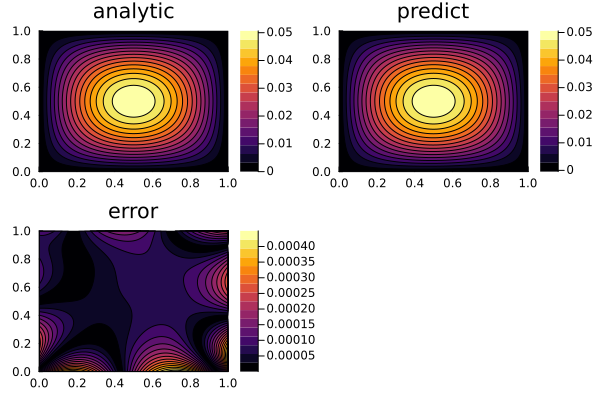

In [13]:
p1 = plot(xs, ys, u_real, linetype=:contourf, title = "analytic");
p2 = plot(xs, ys, u_predict, linetype=:contourf, title = "predict");
p3 = plot(xs, ys, diff_u, linetype=:contourf, title = "error");
plot(p1, p2, p3)